<a href="https://colab.research.google.com/github/trabajogrado28/Tesis/blob/main/Despu%C3%A9s_de_K_medias_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ruta = '/content/drive/MyDrive/fetal2020.csv'
data = pd.read_csv(ruta)

/tmp/ipython-input-3-2976866816.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(ruta)


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.patches import Ellipse
from scipy.stats import entropy
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist
from sklearn.preprocessing import OneHotEncoder,  StandardScaler
from sklearn.neural_network import BernoulliRBM
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from google.colab import drive
from itertools import product
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score # Import necessary functions
import umap
from scipy.stats import entropy
datos_fetal2020 = data
datos_fetal2020.head(6)

,Unnamed: 0,cod_dpto,cod_munic,a_defun,sit_defun,otrsitiode,tipo_defun,ano,mes,hora,...,c_muerteb,c_muertec,c_muerted,c_muertee,asis_med,causa_mult,c_bas1,causa_667,idprofcer,cau_homol
0,0,70,1,1,1,NaN,1,2020.0,5,NaN,...,1.0,NaN,NaN,NaN,1,P018,P018,402,1,80
1,1,11,1,1,1,NaN,1,2020.0,5,NaN,...,1.0,NaN,NaN,NaN,1,P018,P018,402,1,80
2,2,11,1,1,1,NaN,1,2020.0,5,NaN,...,1.0,NaN,NaN,NaN,1,P059/P011,P011,402,1,80
3,3,11,1,1,1,NaN,1,2020.0,5,NaN,...,1.0,NaN,NaN,NaN,1,P018,P018,402,1,80
4,4,11,1,1,1,NaN,1,2020.0,5,NaN,...,1.0,NaN,NaN,NaN,1,P964/P019,P964,406,1,86
5,5,11,1,1,1,NaN,1,2020.0,5,NaN,...,1.0,1.0,NaN,NaN,1,P018,P018,402,1,80


In [5]:
datos_importantes = datos_fetal2020[['cod_dpto', 'seg_social', 'niv_edum', 'edad_madre']]

In [6]:
datos_rangos = datos_importantes[(datos_importantes["seg_social"] < 9) & (datos_importantes["niv_edum"] < 99) & (datos_importantes["edad_madre"] < 99)]
datos_rangos.head(4)

,cod_dpto,seg_social,niv_edum,edad_madre
0,70,2,4,3.0
1,11,1,4,5.0
2,11,5,9,5.0
3,11,5,5,3.0


In [7]:
# Total antes del filtrado
total_original = len(datos_importantes)

# Total después del filtrado
total_filtrado = len(datos_rangos)

# Porcentaje eliminado
porcentaje_eliminado = (total_original - total_filtrado) / total_original * 100

print(f"Porcentaje de datos eliminados: {porcentaje_eliminado:.2f}%")


Porcentaje de datos eliminados: 7.71%


In [8]:
datos_importantes.seg_social.isnull()

,seg_social
0,False
1,False
2,False
3,False
4,False
...,...
33322,False
33323,False
33324,False
33325,False


In [9]:
datos_importantes.edad_madre.isnull()

,edad_madre
0,False
1,False
2,False
3,False
4,False
...,...
33322,False
33323,False
33324,False
33325,False


In [10]:
# Filtra para conservar solo las filas que cumplan con las condiciones (seg_social < 9, niv_edum < 99, edad_madre < 99)
datos_filtros = datos_importantes[(datos_importantes["seg_social"] < 9) &
                                  (datos_importantes["niv_edum"] < 99) &
                                  (datos_importantes["edad_madre"] < 99) ]

# Reemplaza el DataFrame original con los datos filtrados
datos_importantes = datos_filtros

In [11]:
print(datos_filtros)

       cod_dpto  seg_social  niv_edum  edad_madre
0            70           2         4         3.0
1            11           1         4         5.0
2            11           5         9         5.0
3            11           5         5         3.0
4            11           5         4         2.0
...         ...         ...       ...         ...
33322        41           2         2         5.0
33323        11           2         2         2.0
33324        11           5         4         3.0
33325        76           1         3         5.0
33326        11           5         4         5.0

[30758 rows x 4 columns]


In [12]:
from sklearn.preprocessing import OneHotEncoder

# Aplicar One-Hot Encoding a todas las variables categóricas
encoder = OneHotEncoder(sparse_output=False)
data_encoded = encoder.fit_transform(datos_filtros)

In [13]:
print(data_encoded)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [14]:
print(f"numero de variables binarias generadas: {data_encoded.shape[1]}")

numero de variables binarias generadas: 60


In [15]:
# Convertir a DataFrame con los nombres de las columnas
columnas_categoricas = encoder.get_feature_names_out(datos_filtros.columns)
datos_finales = pd.DataFrame(data_encoded, columns=columnas_categoricas)

# Mostrar las primeras filas para verificar
print(datos_finales.head())

   cod_dpto_5  cod_dpto_8  cod_dpto_11  cod_dpto_13  cod_dpto_15  cod_dpto_17  \
0         0.0         0.0          0.0          0.0          0.0          0.0   
1         0.0         0.0          1.0          0.0          0.0          0.0   
2         0.0         0.0          1.0          0.0          0.0          0.0   
3         0.0         0.0          1.0          0.0          0.0          0.0   
4         0.0         0.0          1.0          0.0          0.0          0.0   

   cod_dpto_18  cod_dpto_19  cod_dpto_20  cod_dpto_23  ...  niv_edum_13  \
0          0.0          0.0          0.0          0.0  ...          0.0   
1          0.0          0.0          0.0          0.0  ...          0.0   
2          0.0          0.0          0.0          0.0  ...          0.0   
3          0.0          0.0          0.0          0.0  ...          0.0   
4          0.0          0.0          0.0          0.0  ...          0.0   

   edad_madre_1.0  edad_madre_2.0  edad_madre_3.0  edad_madre_

In [16]:
def calcular_entropia_global(df):
    entropias = {}
    for col in df.columns:
        conteo = df[col].value_counts(normalize=True)  # Probabilidad de cada categoría
        entropia_columna = entropy(conteo, base=2)  # Entropía de Shannon
        entropias[col] = entropia_columna
    return entropias

In [17]:
# Aplicar la función a las variables categóricas
variables_categoricas = ['cod_dpto_5', 'cod_dpto_8', 'cod_dpto_11', 'cod_dpto_13', 'cod_dpto_15',
       'cod_dpto_17', 'cod_dpto_18', 'cod_dpto_19', 'cod_dpto_20',
       'cod_dpto_23', 'cod_dpto_25', 'cod_dpto_27', 'cod_dpto_41',
       'cod_dpto_44', 'cod_dpto_47', 'cod_dpto_50', 'cod_dpto_52',
       'cod_dpto_54', 'cod_dpto_63', 'cod_dpto_66', 'cod_dpto_68',
       'cod_dpto_70', 'cod_dpto_73', 'cod_dpto_76', 'cod_dpto_81',
       'cod_dpto_85', 'cod_dpto_86', 'cod_dpto_88', 'cod_dpto_91',
       'cod_dpto_94', 'cod_dpto_95', 'cod_dpto_97', 'cod_dpto_99',
       'seg_social_1', 'seg_social_2', 'seg_social_3', 'seg_social_4',
       'seg_social_5', 'niv_edum_1', 'niv_edum_2', 'niv_edum_3', 'niv_edum_4',
       'niv_edum_5', 'niv_edum_6', 'niv_edum_7', 'niv_edum_8', 'niv_edum_9',
       'niv_edum_10', 'niv_edum_11', 'niv_edum_12', 'niv_edum_13',
       'edad_madre_1.0', 'edad_madre_2.0', 'edad_madre_3.0', 'edad_madre_4.0',
       'edad_madre_5.0', 'edad_madre_6.0', 'edad_madre_7.0', 'edad_madre_8.0',
       'edad_madre_9.0']
entropias = calcular_entropia_global(datos_finales[variables_categoricas])

In [18]:
# Mostrar los resultados
for var, ent in entropias.items():
    print(f"Entropía de {var}: {ent:.4f}")

Entropía de cod_dpto_5: 0.4982
Entropía de cod_dpto_8: 0.1423
Entropía de cod_dpto_11: 0.7799
Entropía de cod_dpto_13: 0.1298
Entropía de cod_dpto_15: 0.1031
Entropía de cod_dpto_17: 0.0589
Entropía de cod_dpto_18: 0.0774
Entropía de cod_dpto_19: 0.0765
Entropía de cod_dpto_20: 0.0640
Entropía de cod_dpto_23: 0.3748
Entropía de cod_dpto_25: 0.2570
Entropía de cod_dpto_27: 0.0277
Entropía de cod_dpto_41: 0.2842
Entropía de cod_dpto_44: 0.0624
Entropía de cod_dpto_47: 0.1836
Entropía de cod_dpto_50: 0.1736
Entropía de cod_dpto_52: 0.2680
Entropía de cod_dpto_54: 0.2931
Entropía de cod_dpto_63: 0.0302
Entropía de cod_dpto_66: 0.0779
Entropía de cod_dpto_68: 0.2303
Entropía de cod_dpto_70: 0.2172
Entropía de cod_dpto_73: 0.1168
Entropía de cod_dpto_76: 0.4620
Entropía de cod_dpto_81: 0.1531
Entropía de cod_dpto_85: 0.0204
Entropía de cod_dpto_86: 0.1195
Entropía de cod_dpto_88: 0.0371
Entropía de cod_dpto_91: 0.0057
Entropía de cod_dpto_94: 0.0061
Entropía de cod_dpto_95: 0.0269
Entropía d

In [19]:
# Normalizar los datos codificados entre 0 y 1 antes de RBM
scaler = MinMaxScaler()
datos_normalizados = scaler.fit_transform(datos_finales)

In [20]:
# Configuración de la Máquina de Boltzmann Restringida (RBM)
rbm = BernoulliRBM(n_components=10, learning_rate=0.01, n_iter=100, random_state=42)

# Entrenar la RBM
datos_rbm = rbm.fit_transform(datos_normalizados)

# Convertir a DataFrame para visualización
datos_rbm_df = pd.DataFrame(datos_rbm)

# Mostrar las primeras filas de las características aprendidas por la RBM
print("Representaciones aprendidas por la RBM:")
print(datos_rbm_df.head())

Representaciones aprendidas por la RBM:
          0         1         2         3         4         5         6  \
0  0.050589  0.993042  0.000273  0.000653  0.999910  0.999922  0.891045   
1  0.001550  0.999194  0.999298  0.999818  0.999920  0.000160  0.005129   
2  0.002357  0.986859  0.999952  0.999609  0.992370  0.999589  0.000004   
3  0.020769  0.843205  0.999975  0.000232  0.003450  0.999976  0.013183   
4  0.990529  0.412500  0.999156  0.996726  0.999936  0.997619  0.000014   

          7         8         9  
0  0.000382  0.997648  0.999880  
1  0.993660  0.979810  0.999423  
2  0.997922  0.947139  0.000017  
3  0.997822  0.993814  0.005542  
4  0.997856  0.243472  0.999995  


In [21]:
import numpy as np
import pandas as pd

# Obtener nombres de columnas originales después del One-Hot Encoding
columnas_originales = datos_finales.columns

# Extraer matriz de pesos de la RBM
pesos_rbm = rbm.components_

# Mostrar las 5 variables más influyentes por latente
for i, latente in enumerate(pesos_rbm):
    print(f"\n🔹 Latente {i}:")
    top_idx = np.argsort(np.abs(latente))[-5:]  # 5 variables con mayor valor absoluto
    for idx in reversed(top_idx):
        print(f"  {columnas_originales[idx]}: peso = {latente[idx]:.4f}")


🔹 Latente 0:
  edad_madre_2.0: peso = 6.4048
  niv_edum_2: peso = 6.2865
  edad_madre_5.0: peso = -3.7782
  niv_edum_7: peso = -3.5066
  edad_madre_4.0: peso = -3.4684

🔹 Latente 1:
  edad_madre_4.0: peso = -8.9142
  edad_madre_6.0: peso = 4.1793
  edad_madre_5.0: peso = 3.5709
  seg_social_5: peso = -2.4039
  edad_madre_7.0: peso = 2.0409

🔹 Latente 2:
  seg_social_2: peso = -9.9556
  seg_social_5: peso = 6.3570
  seg_social_1: peso = 6.2775
  seg_social_3: peso = 2.3214
  niv_edum_4: peso = -2.1052

🔹 Latente 3:
  edad_madre_3.0: peso = -11.4069
  edad_madre_4.0: peso = 5.7223
  edad_madre_5.0: peso = 4.3949
  edad_madre_6.0: peso = 3.9575
  edad_madre_2.0: peso = 3.6547

🔹 Latente 4:
  niv_edum_4: peso = 11.8070
  niv_edum_3: peso = -10.3450
  niv_edum_9: peso = 7.4142
  niv_edum_7: peso = -5.0706
  niv_edum_2: peso = -4.1925

🔹 Latente 5:
  seg_social_1: peso = -9.7328
  seg_social_2: peso = 5.8770
  seg_social_5: peso = 5.7714
  seg_social_3: peso = 2.8779
  niv_edum_10: peso = -

In [22]:
# Calcular la reconstrucción manualmente
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

# Propagar hacia la capa oculta
activaciones_ocultas = sigmoide(np.dot(data_encoded, rbm.components_.T) + rbm.intercept_hidden_)

# Reconstruir la entrada desde la capa oculta
X_reconstruido = sigmoide(np.dot(activaciones_ocultas, rbm.components_) + rbm.intercept_visible_)

# Calcular el error de reconstrucción
error_reconstruccion = np.mean((data_encoded - X_reconstruido) ** 2)
print(f"Error de reconstrucción de la RBM: {error_reconstruccion}")

Error de reconstrucción de la RBM: 0.0156663118801355


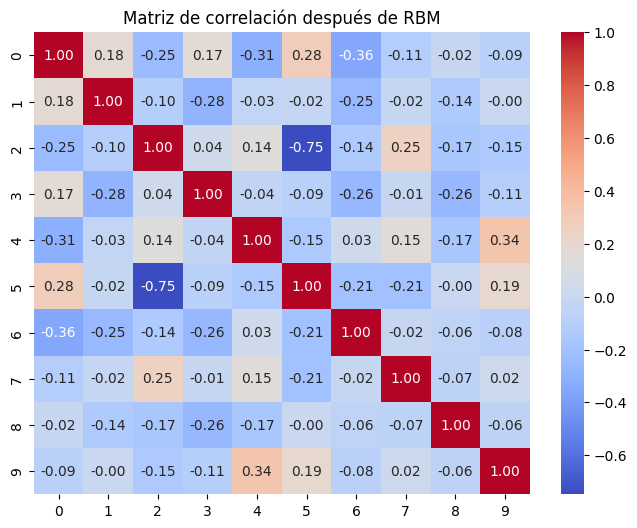

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculamos la matriz de correlación de las variables después de la RBM
correlation_matrix = pd.DataFrame(datos_rbm).corr()

# Graficamos la matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación después de RBM")
plt.show()

# **K-medias**

In [24]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(datos_rbm)  # Usar la variable correcta que contiene las características transformadas por la RBM

# Asignar los clusters al DataFrame original
datos_importantes["Cluster"] = kmeans.labels_

# Ver las primeras filas con los clusters asignados
print(datos_importantes.head())

   cod_dpto  seg_social  niv_edum  edad_madre  Cluster
0        70           2         4         3.0        2
1        11           1         4         5.0        1
2        11           5         9         5.0        1
3        11           5         5         3.0        1
4        11           5         4         2.0        1


Estadísticas descriptivas por cluster:
          cod_dpto  seg_social  niv_edum  edad_madre
Cluster                                             
0        32.196009    1.000000  5.929461    4.535862
1        32.201874    3.296956  4.101483    3.463232
2        39.604131    2.000000  3.911161    4.086456
3        40.764450    2.332884  3.756514    3.749326


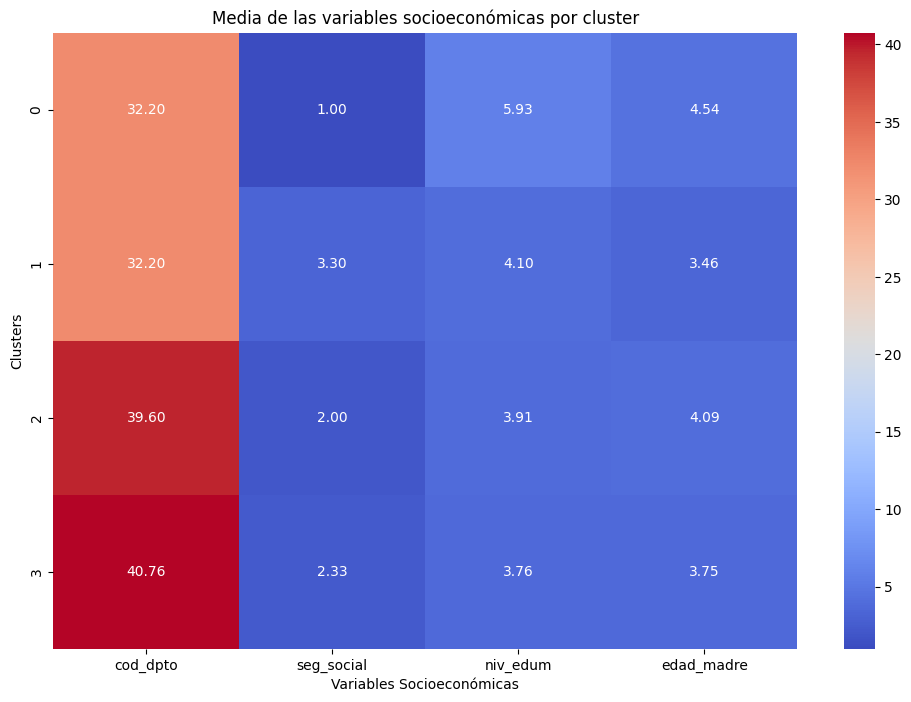

In [25]:
# Agrupar por cluster y calcular estadísticas
estadisticas_cluster = datos_importantes.groupby("Cluster").mean()

print("Estadísticas descriptivas por cluster:")
print(estadisticas_cluster)

# Visualizar las estadísticas con un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(estadisticas_cluster, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Media de las variables socioeconómicas por cluster")
plt.xlabel("Variables Socioeconómicas")
plt.ylabel("Clusters")
plt.show()

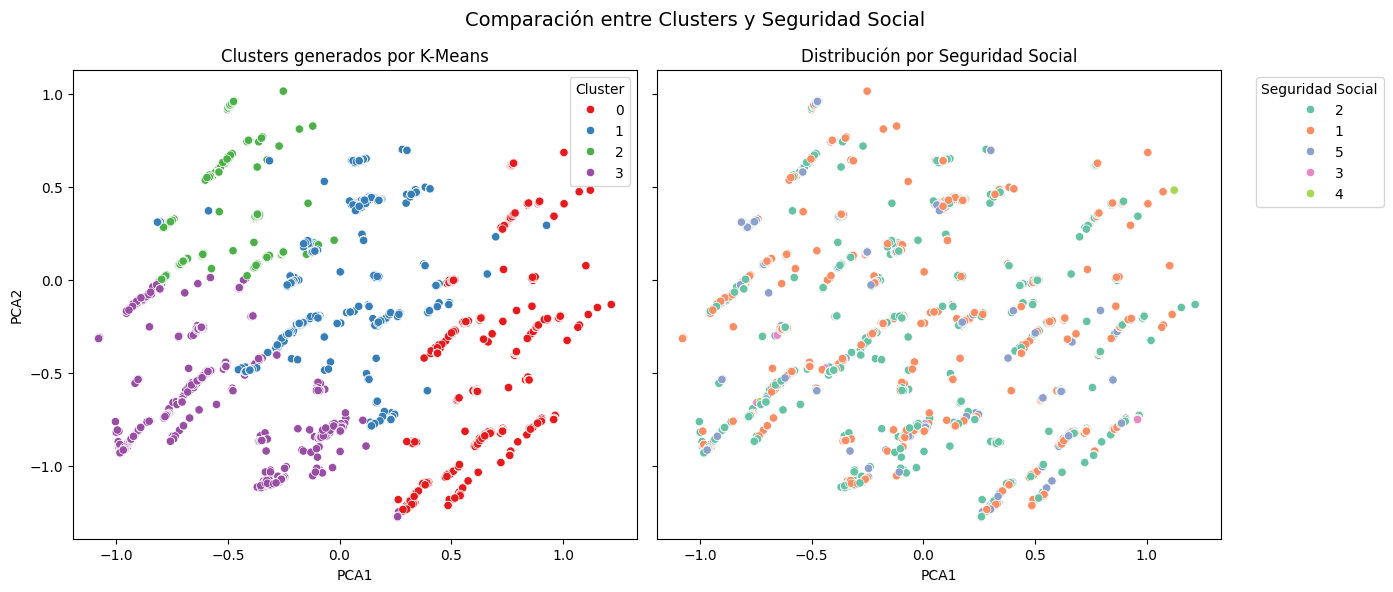

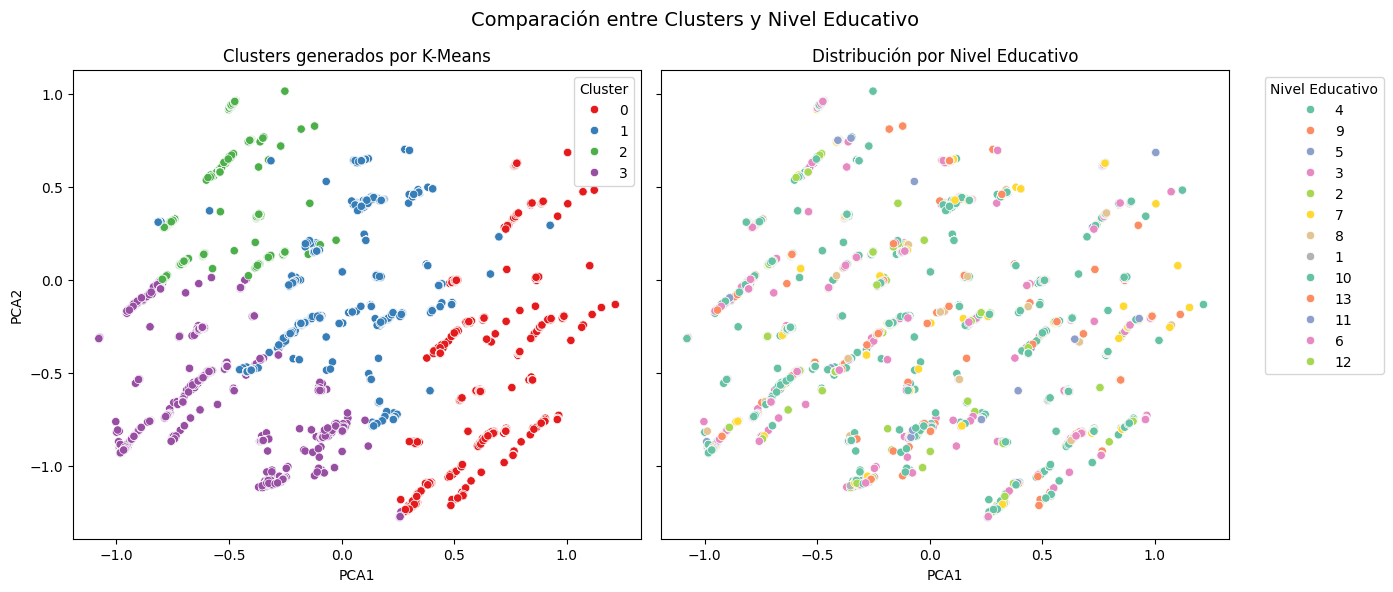

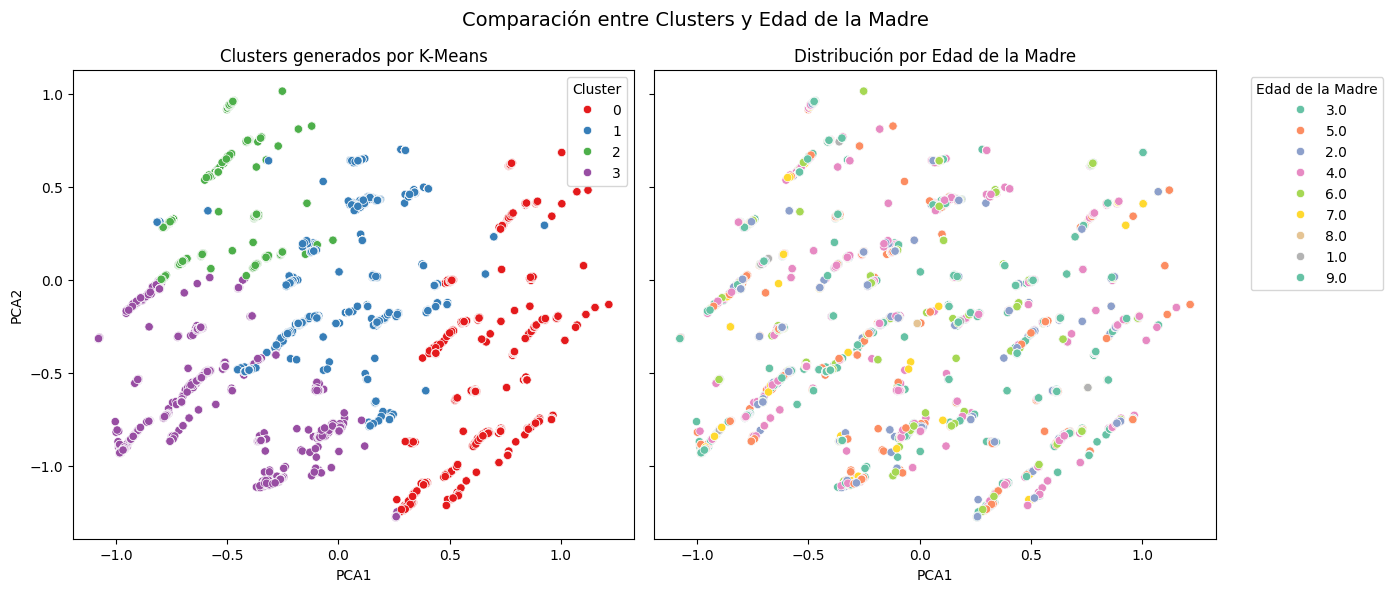

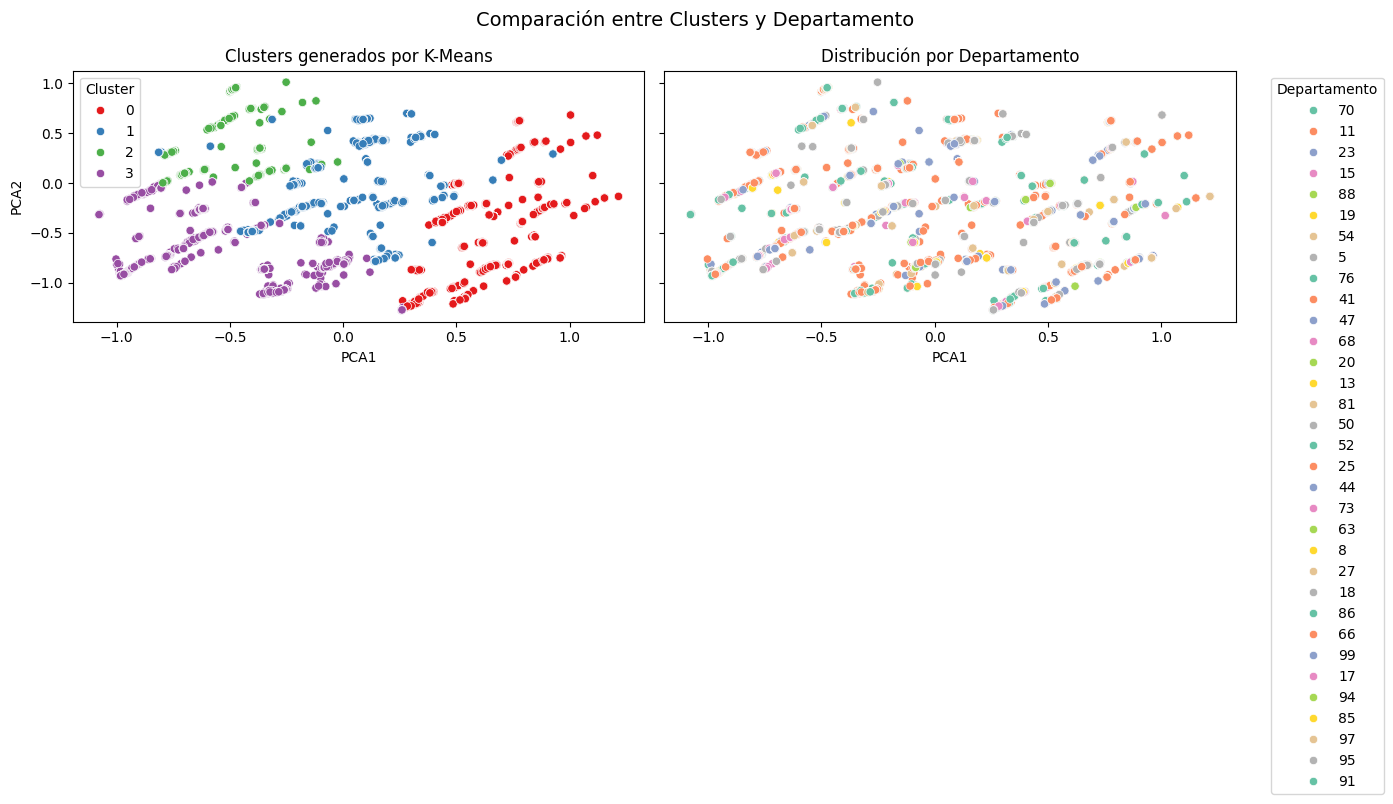

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Aplicar PCA para proyectar los datos a 2D (si ya lo hiciste antes puedes saltar esto)
pca = PCA(n_components=2)
datos_pca = pca.fit_transform(datos_rbm)

# Crear un DataFrame base para graficar
df_base = pd.DataFrame(datos_pca, columns=["PCA1", "PCA2"])
df_base["Cluster"] = kmeans.labels_

# Lista de variables originales para comparar
variables_originales = {
    "seg_social": "Seguridad Social",
    "niv_edum": "Nivel Educativo",
    "edad_madre": "Edad de la Madre",
    "cod_dpto": "Departamento"
}

# Crear una figura por cada variable comparando los clústeres con la variable original
for var, nombre in variables_originales.items():
    df_base["Referencia"] = datos_importantes[var].astype(str)  # convertir a string para usar como categoría

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

    sns.scatterplot(data=df_base, x="PCA1", y="PCA2", hue="Cluster", palette="Set1", ax=axes[0])
    axes[0].set_title("Clusters generados por K-Means")
    axes[0].legend(title="Cluster")

    sns.scatterplot(data=df_base, x="PCA1", y="PCA2", hue="Referencia", palette="Set2", ax=axes[1])
    axes[1].set_title(f"Distribución por {nombre}")
    axes[1].legend(title=nombre, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.suptitle(f"Comparación entre Clusters y {nombre}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [27]:
from scipy.stats import entropy

def calcular_entropia_por_cluster(df, cluster_col, variable_col):
    entropias = {}

    for cluster_id in sorted(df[cluster_col].unique()):
        grupo = df[df[cluster_col] == cluster_id][variable_col]
        conteo = grupo.value_counts(normalize=True)
        ent = entropy(conteo, base=2)
        entropias[cluster_id] = ent

    return entropias

# Variables que quieres evaluar
variables = ['cod_dpto', 'edad_madre', 'niv_edum', 'seg_social']

# Calcular y mostrar entropías
for var in variables:
    entropias = calcular_entropia_por_cluster(datos_importantes, 'Cluster', var)
    print(f"\nEntropía por cluster respecto a '{var}':")
    for cluster, ent in entropias.items():
        print(f"  Cluster {cluster}: Entropía = {ent:.4f} bits")


Entropía por cluster respecto a 'cod_dpto':
  Cluster 0: Entropía = 3.3662 bits
  Cluster 1: Entropía = 3.6775 bits
  Cluster 2: Entropía = 4.2052 bits
  Cluster 3: Entropía = 4.4339 bits

Entropía por cluster respecto a 'edad_madre':
  Cluster 0: Entropía = 2.3616 bits
  Cluster 1: Entropía = 2.2077 bits
  Cluster 2: Entropía = 1.9911 bits
  Cluster 3: Entropía = 2.6111 bits

Entropía por cluster respecto a 'niv_edum':
  Cluster 0: Entropía = 2.5662 bits
  Cluster 1: Entropía = 1.2353 bits
  Cluster 2: Entropía = 1.1337 bits
  Cluster 3: Entropía = 2.1914 bits

Entropía por cluster respecto a 'seg_social':
  Cluster 0: Entropía = 0.0000 bits
  Cluster 1: Entropía = 1.6928 bits
  Cluster 2: Entropía = 0.0000 bits
  Cluster 3: Entropía = 0.6939 bits


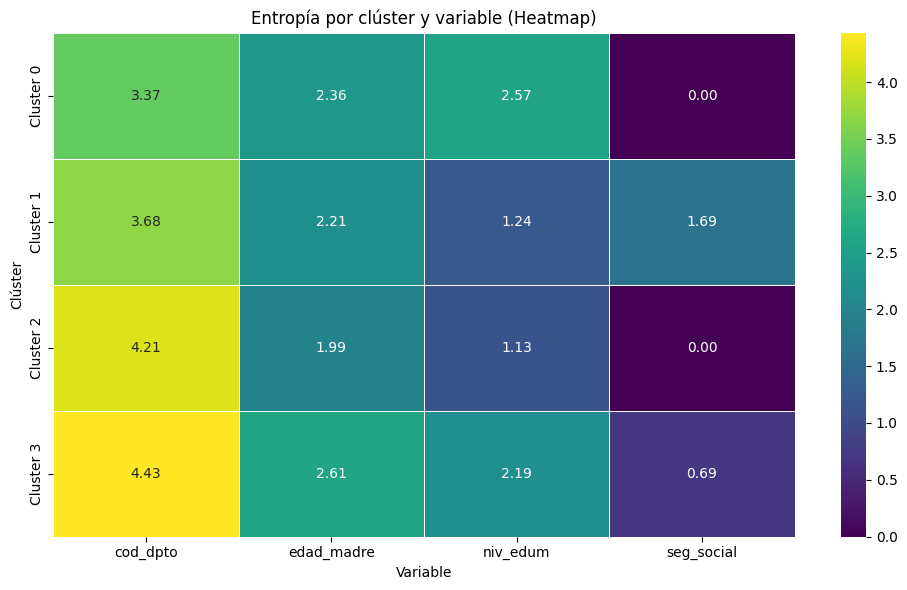

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Crear DataFrame de entropía si no lo tienes ya
df_entropia = pd.DataFrame({
    'cod_dpto': [3.3662, 3.6775, 4.2052, 4.4339],
    'edad_madre': [2.3616, 2.2077, 1.9911, 2.6111],
    'niv_edum': [2.5662, 1.2353, 1.1337, 2.1914],
    'seg_social': [0.0000, 1.6928, 0.0000, 0.6939]
}, index=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'])

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_entropia, annot=True, cmap="viridis", fmt=".2f", linewidths=0.5)
plt.title("Entropía por clúster y variable (Heatmap)")
plt.xlabel("Variable")
plt.ylabel("Clúster")
plt.tight_layout()
plt.show()


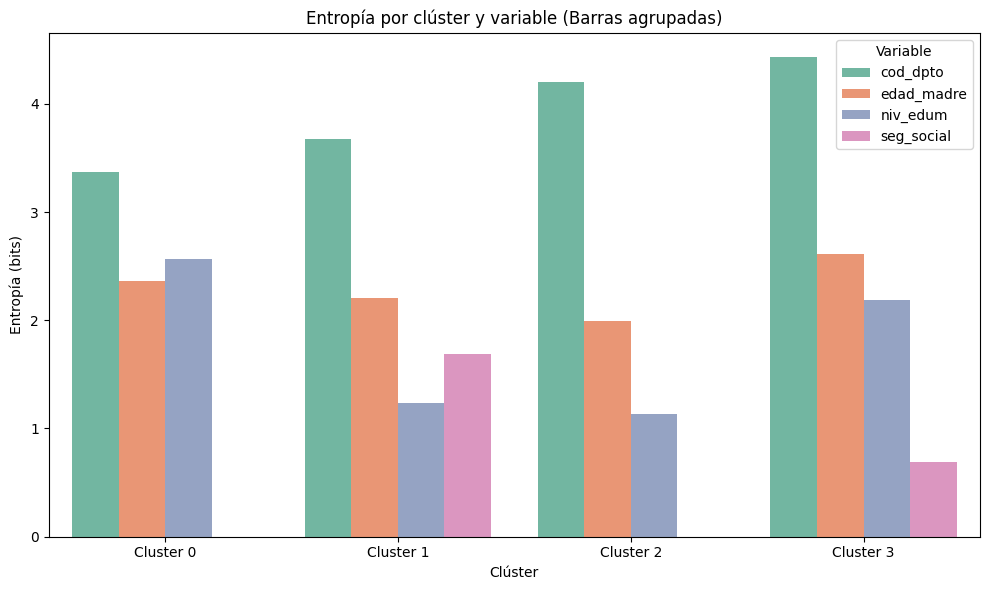

In [29]:
# Reorganizar los datos para el gráfico de barras
df_entropia_bar = df_entropia.reset_index().melt(id_vars="index", var_name="Variable", value_name="Entropía")
df_entropia_bar.rename(columns={"index": "Clúster"}, inplace=True)

# Barras agrupadas
plt.figure(figsize=(10, 6))
sns.barplot(data=df_entropia_bar, x="Clúster", y="Entropía", hue="Variable", palette="Set2")
plt.title("Entropía por clúster y variable (Barras agrupadas)")
plt.ylabel("Entropía (bits)")
plt.xlabel("Clúster")
plt.legend(title="Variable")
plt.tight_layout()
plt.show()
